In [1]:

import tensorflow as tf
import tensorflow_datasets as tfds

#Descargar set de datos de MNIST (Numeros escritos a mano, etiquetados)
datos, metadatos = tfds.load('mnist', as_supervised=True, with_info=True)

#Obtener en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

#Funcion de normalizacion para los datos (Pasar valor de los pixeles de 0-255 a 0-1)
#(Hace que la red aprenda mejor y mas rapido)
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui se pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

clases = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:   0%|          | 0/4 [00:00<?, ? url/s]


Dl Completed...:  50%|█████     | 2/4 [00:00<00:00,  3.22 url/s]

Dl Completed...:  75%|███████▌  | 3/4 [00:00<00:00,  3.61 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:01<00:00,  2.91 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:01<00:00,  2.56 url/s]


Dataset mnist downloaded and prepared to C:\Users\javie\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


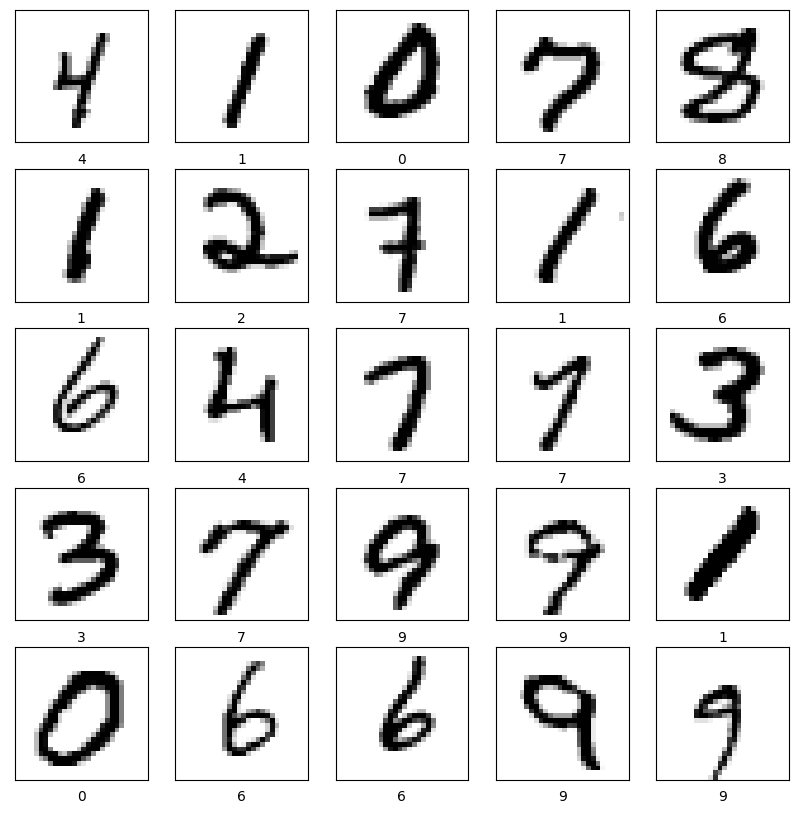

In [2]:
#Codigo para mostrar imagenes del set, no es necesario ejecutarlo, solo imprime unos numeros :)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(clases[etiqueta])

plt.show()  

In [3]:
#Crear el modelo (Ya utiliza capas de convolución y agrupación)
#Cuenta con 1 capa de convolución con 32 núcleos y otra con 64. 2 capas de agrupación.
#Finalmente una capa densa con 100 neuronas
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamano de la matriz

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamano de la matriz

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [4]:
#Los numeros de datos de entrenamiento y pruebas (60k y 10k)
num_datos_entrenamiento = metadatos.splits["train"].num_examples
num_datos_pruebas = metadatos.splits["test"].num_examples

#Trabajar por lotes
TAMANO_LOTE=32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria
#para que el entrenamiento no se aprenda las cosas en orden
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_datos_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [5]:
#Realizar el entrenamiento
import math

historial = modelo.fit(
    datos_entrenamiento,
    epochs=60,
    steps_per_epoch=math.ceil(num_datos_entrenamiento/TAMANO_LOTE)
)

Epoch 1/60
1875/1875 [==============================] - 22s 11ms/step - loss: 0.1311 - accuracy: 0.9607
Epoch 2/60
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0438 - accuracy: 0.9862
Epoch 3/60
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0278 - accuracy: 0.9912
Epoch 4/60
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0226 - accuracy: 0.9932
Epoch 5/60
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0175 - accuracy: 0.9944
Epoch 6/60
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0129 - accuracy: 0.9960
Epoch 7/60
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0101 - accuracy: 0.9968
Epoch 8/60
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0089 - accuracy: 0.9970
Epoch 9/60
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0074 - accuracy: 0.9975
Epoch 10/60
1875/1875 [==============================] - 24s 13m

In [6]:
#Exportar el modelo al explorador! 
modelo.save('numeros_conv.h5')

#Convertirlo a tensorflow.js
!pip install tensorflowjs

!mkdir carpeta_salida

!tensorflowjs_converter --input_format keras numeros_conv.h5 carpeta_salida

  Using cached tensorflowjs-4.1.0-py3-none-any.whl (84 kB)
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached jax-0.4.1.tar.gz (1.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached packaging-20.9-py2.py3-none-any.whl (40 kB)
  Using cached flax-0.6.3-py3-none-any.whl (197 kB)
  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl (895 kB)
  Using cached tensorflowjs-4.0.0-py3-none-any.whl (83 kB)
  Using cached tensorflowjs-3.21.0-py3-none-any.whl (81 kB)
  Using cached msgpack-1.0.4-cp310-cp310-win_amd64.whl (61 kB)
  Using cached rich-12.6.0-py3-none-any.whl (237 kB)
  Using cached tensorstore-0.1.28-cp310-cp310-win_amd64.whl (6.5 MB)
  Using cached optax-0.1.4-py3-none-any.whl (154 kB)
  Using cached orbax-0.0.23-py3-none-any.whl (66 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached flatbuffers-22.12.6-py2.py3-none-any.whl (26 kB)
  Using cached tensorf

ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\javie\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.

"tensorflowjs_converter" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
